In [1]:
import os
import random
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import time

%matplotlib inline

Let's configure all random numbers generators to support determinism and obtain reproducible results.

In [2]:
%pip install mlxtend --upgrade

In [3]:
# settings for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'


Initializing parameters

In [4]:
size_input = 784
size_hidden = 256
size_output = 10
number_of_train_examples = 60000
number_of_test_examples = 10000

# Load Data

Keras comes with the MNIST data loader. Keras has a function `mnist.load_data()` which downloads the data from its servers if it is not present already. The data loaded using this function is divided into training and test sets.

In [5]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Checkout the data

The data consists of handwritten numbers ranging from 0 to 9, along with their ground truth. It has 60,000 train samples and 10,000 test samples. Each sample is a 28x28 grayscale image.

In [6]:
from tensorflow.keras.utils import to_categorical

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Ground Truth : 7')

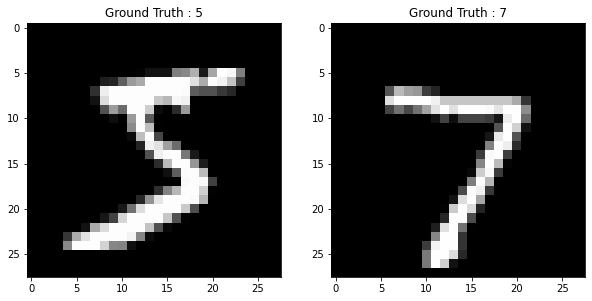

In [7]:
print('Training data shape : ', train_images.shape, train_labels.shape)

print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
classes_num = len(classes)
print('Total number of outputs : ', classes_num)
print('Output classes : ', classes)

plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[0]))


# Process the data

* The images are grayscale and the pixel values range from 0 to 255.
* Convert each image matrix ( 28x28 ) to an array ( 28*28 = 784 dimenstional ) which will be fed to the network as a single feature.
* We convert the data to float and **scale** the values between 0 to 1.
* We also convert the labels from integer to **categorical ( one-hot ) encoding** since that is the format required by Keras to perform multiclass classification. One-hot encoding is a type of boolean representation of integer data. It converts the integer to an array of all zeros except a 1 at the index of the number. For example, using a one-hot encoding of 10 classes, the integer 5 will be encoded as 0000010000

In [8]:
# Change from matrix to array of dimension 28x28 to array of dimention 784
dim_data = np.prod(train_images.shape[1:])
train_data = train_images.reshape(train_images.shape[0], dim_data)
test_data = test_images.reshape(test_images.shape[0], dim_data)

input_shape=(dim_data,)

In [9]:
# Change to float datatype
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

In [10]:
# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

In [11]:
# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

In [12]:
# Display the change for category label using one-hot encoding
print('Original label 0 : ', train_labels[0])
print('After conversion to categorical ( one-hot ) : ', train_labels_one_hot[0])

Original label 0 :  5
After conversion to categorical ( one-hot ) :  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [13]:
from keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Create the network

In [14]:
# Define class to build mlp model

class MLP_L2(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))


     # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2,self.b3,self.b4]


    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    lambd = 1e-5
    m = y_true.shape[1]
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    L2_regularization_cost = lambd / (m * 2) * (np.sum(np.square(self.W1))+np.sum(np.square(self.W2))+np.sum(np.square(self.W3))+np.sum(np.square(self.W4)))
    ### END CODER HERE ###
    cost = tf.losses.mean_squared_error(y_true, y_pred)
    cost = cost + L2_regularization_cost
    
    return cost

  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

   
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer

    X_tf = X_tf/np.linalg.norm(X_tf)

    what = tf.matmul(X_tf, self.W1) + self.b1
    #what = np.linalg.norm(tf.matmul(X_tf, self.W1) + self.b1)
    hhat = tf.nn.relu(what)
    #hhat = np.linalg.norm(tf.nn.relu(what))

  
    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)
    #hhat_2 = np.linalg.norm(tf.nn.relu(what_2))

    what_3 = tf.matmul(hhat_2, self.W3) + self.b3
    hhat_3 = tf.nn.relu(what_3)
    #hhat = np.linalg.norm(tf.nn.relu(what_3))

    # Compute output
    output = tf.matmul(hhat_3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output) 

In [15]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))



    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))

    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))



    # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4, self.b1, self.b2,self.b3,self.b4]

    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    X_tf = X_tf/np.linalg.norm(X_tf)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)


    what_2 = tf.matmul(hhat, self.W2) + self.b2
    hhat_2 = tf.nn.relu(what_2)

    what_3 = tf.matmul(hhat_2, self.W3) + self.b3
    hhat_3 = tf.nn.relu(what_3)
    # Compute output
    output = tf.matmul(hhat_3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output)

In [25]:
# Define class to build mlp model
class MLP_DROPOUT(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
   # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))


    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))


    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_hidden]))


     # Initialize weights between hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3,self.W4,self.b1,self.b2,self.b3,self.W4]


 
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    p= 0.9
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)

    X_tf = X_tf/np.linalg.norm(X_tf)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    what = what * np.random.binomial(1, p, size = what.shape) /p
    hhat = tf.nn.relu(what)

    


    what_2 = tf.matmul(hhat, self.W2) + self.b2
    what_2 = what_2 * np.random.binomial(1, p, size = what_2.shape)/p
    hhat_2 = tf.nn.relu(what_2)
    


    what_3 = tf.matmul(hhat_2, self.W3) + self.b3
    what_3 = what_3 * np.random.binomial(1, p, size = what_3.shape) /p
    hhat_3 = tf.nn.relu(what_3)
    




    # Compute output
    output = tf.matmul(hhat_3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output)

Number of Epoch = 1 - Average MSE:= 0.18044267578125
Number of Epoch = 2 - Average MSE:= 0.18027783203125
Number of Epoch = 3 - Average MSE:= 0.18030234375
Number of Epoch = 4 - Average MSE:= 0.18031575520833334
Number of Epoch = 5 - Average MSE:= 0.18026998697916666
Number of Epoch = 6 - Average MSE:= 0.18028211263020832
Number of Epoch = 7 - Average MSE:= 0.18026031901041667
Number of Epoch = 8 - Average MSE:= 0.18027117513020832
Number of Epoch = 9 - Average MSE:= 0.18026442057291667
Number of Epoch = 10 - Average MSE:= 0.180261181640625
Number of Epoch = 11 - Average MSE:= 0.18026119791666667
early stopping at epoch: 11

Total time taken (in seconds): 441.06


In [41]:
from numpy.core.fromnumeric import var
def main(model_type):
  NUM_EPOCHS = 10
  if(model_type == 'MLP'):
    mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='gpu')
  if(model_type == 'DROPOUT'):
    mlp_on_cpu = MLP_DROPOUT(size_input, size_hidden, size_output, device='gpu')
  if(model_type == 'L2'):
    mlp_on_cpu = MLP_L2(size_input, size_hidden, size_output, device='gpu')
  

  time_start = time.time()
  saved_model  = mlp_on_cpu.variables
  train_loss = np.empty(NUM_EPOCHS)
  test_loss = np.empty(NUM_EPOCHS)

  epoch_length = 0
  useless = 0

  for epoch in range(NUM_EPOCHS):
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
    test_loss_total = tf.Variable(0, dtype=tf.float32)
    #train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(25, seed=epoch*(1234)).batch(20)
  
    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels_one_hot)).shuffle(32, seed=epoch*(1234)).batch(32)
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels_one_hot)).shuffle(32, seed=epoch*(1234)).batch(32)

    ##feed into the MLP model
    for inputs, outputs in train_ds:
      preds = mlp_on_cpu.forward(inputs)
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

  
      #      saved_model  = mlp_on_cpu.variables
  #      useless = 0
  #    else:
  #      useless = useless + 1
  #      if(useless == 4):
  #        print('early stopping at epoch:', epoch)
  #        epoch_length = epoch
  #        break
    if( epoch > 10):
      if( np.mean(train_loss[epoch-4:epoch-1]) < (np.sum(loss_total)/train_data.shape[0])):
        print('early stopping at epoch:', epoch)
        break


  #test_loss_total = 0.0
  #for inputs, outputs in test_ds:
  #  preds = mlp_on_cpu.forward(inputs)
  #  b = mlp_on_cpu.loss(preds, outputs)
  #  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)

  #test_loss[epoch] = np.sum(test_loss_total)/test_data.shape[0]
  #train_loss[epoch] = np.sum(loss_total)/train_data.shape[0]

    print('Number of Epoch = {} - Average MSE:= {}'.format(epoch + 1, np.sum(loss_total) / train_data.shape[0]))

  time_taken = time.time() - time_start
  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))



  preds = mlp_on_cpu.forward(test_data)
  #precision_m(test_labels_one_hot, preds)
  print("precision for current model:",model_type,"--------",precision_m(test_labels_one_hot,preds))
  var = np.var(preds - test_labels_one_hot)
  mean = np.mean(preds) - np.mean(test_labels_one_hot)
  print("var = ", var)
  prec = precision_m(test_labels_one_hot,preds)
  return mean, var, prec


"""
  avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        mlp_on_cpu, train_data,train_labels_one_hot, test_data, test_labels_one_hot, 
        loss='mse',
        random_seed=123)
"""




"\n  avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(\n        mlp_on_cpu, train_data,train_labels_one_hot, test_data, test_labels_one_hot, \n        loss='mse',\n        random_seed=123)\n"

************************************* RUN---- 1
Number of Epoch = 1 - Average MSE:= 0.18049788411458334
Number of Epoch = 2 - Average MSE:= 0.18049788411458334
Number of Epoch = 3 - Average MSE:= 0.18049788411458334
Number of Epoch = 4 - Average MSE:= 0.18049786783854166
Number of Epoch = 5 - Average MSE:= 0.18049786783854166
Number of Epoch = 6 - Average MSE:= 0.18049786783854166
Number of Epoch = 7 - Average MSE:= 0.18049786783854166
Number of Epoch = 8 - Average MSE:= 0.18049786783854166
Number of Epoch = 9 - Average MSE:= 0.18049786783854166
Number of Epoch = 10 - Average MSE:= 0.18049786783854166

Total time taken (in seconds): 347.80
precision for current model: MLP -------- tf.Tensor(0.0974, shape=(), dtype=float32)
var =  0.18052
************************************* RUN---- 2
Number of Epoch = 1 - Average MSE:= 0.18090138346354168
Number of Epoch = 2 - Average MSE:= 0.1803298828125
Number of Epoch = 3 - Average MSE:= 0.18031585286458332
Number of Epoch = 4 - Average MSE:= 0.18

Text(0.5, 1.0, 'Variance')

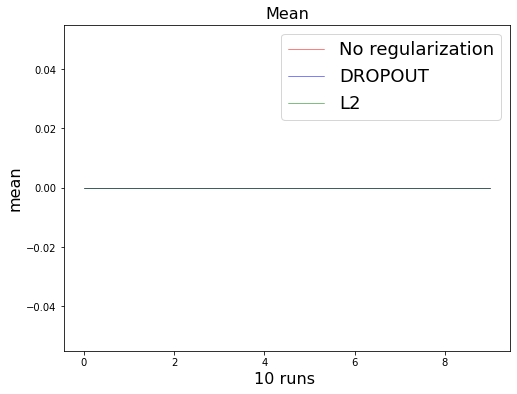

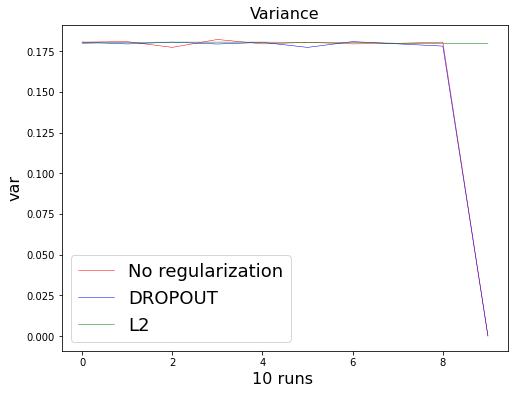

In [43]:
from mlxtend.evaluate import bias_variance_decomp
mean1 = [0]*10
mean2 = [0]*10
mean3 = [0]*10
prec1 = [0] * 10
prec2 = [0] * 10
prec3 = [0] * 10
var1 = [0]*10
var2 = [0]*10
var3 = [0]*10

for i in range(1,10):
  print("************************************* RUN----", i)
  seed = 8.2*i
  
  mean1[i-1], var1[i-1],prec1[i-1] = main('MLP')
  


for i in range(1,10):
  print("************************************* RUN----", i)
  seed = 8.2*i
  main('DROPOUT')
  mean2[i-1], var2[i-1],prec2[i-1] = main('DROPOUT')


for i in range(10):
  print("************************************* RUN----", i)
  seed = 8.2*i
  mean3[i-1], var3[i-1],prec3[i-1] = main('L2')




plt.figure(figsize=[8,6])
plt.plot(mean1,'r',linewidth=0.5)
plt.plot(mean2,'b',linewidth=0.5)
plt.plot(mean3,'g',linewidth=0.5)
plt.legend(['No regularization', 'DROPOUT','L2'],fontsize=18)
plt.xlabel('10 runs ',fontsize=16)
plt.ylabel('mean',fontsize=16)
plt.title('Mean',fontsize=16)





plt.figure(figsize=[8,6])
plt.plot(var1,'r',linewidth=0.5)
plt.plot(var2,'b',linewidth=0.5)
plt.plot(var3,'g',linewidth=0.5)
plt.legend(['No regularization', 'DROPOUT','L2'],fontsize=18)
plt.xlabel('10 runs ',fontsize=16)
plt.ylabel('var',fontsize=16)
plt.title('Variance',fontsize=16)
  

  



Text(0.5, 1.0, 'Preciosn')

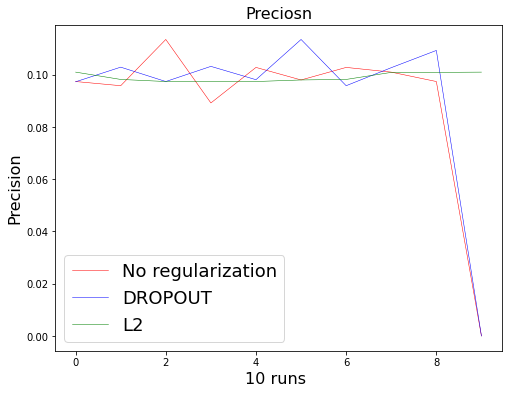

In [44]:
plt.figure(figsize=[8,6])
plt.plot(prec1,'r',linewidth=0.5)
plt.plot(prec2,'b',linewidth=0.5)
plt.plot(prec3,'g',linewidth=0.5)
plt.legend(['No regularization', 'DROPOUT','L2'],fontsize=18)
plt.xlabel('10 runs ',fontsize=16)
plt.ylabel('Precision',fontsize=16)
plt.title('Preciosn',fontsize=16)

Text(0.5, 1.0, 'Loss Curves')

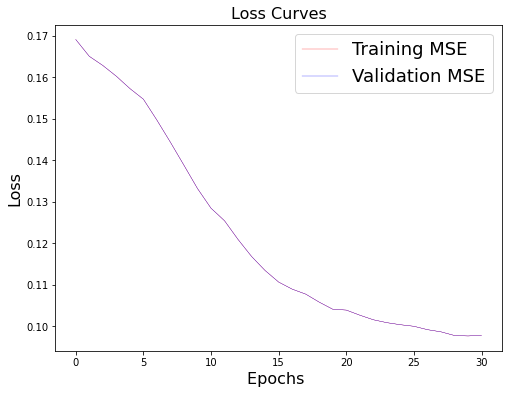

In [42]:
## This was done when I only have W1, W2, W3. adding W4 ruined everything

plt.figure(figsize=[8,6])
plt.plot(train_loss[1:epoch_length],'r',linewidth=0.3)
plt.plot(train_loss[1:epoch_length],'b',linewidth=0.3)
plt.legend(['Training MSE', 'Validation MSE'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)